In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
from utils import *


import cvxpy as cp
import gurobipy as gp
from gurobipy import GRB

## Create data

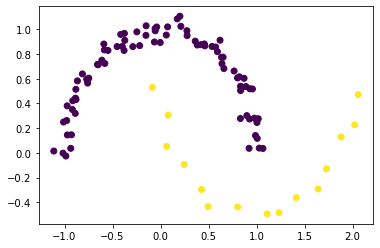

In [2]:
## number of samples
N = 100

np.random.seed(10)
x,y=make_moons(n_samples=(N-15,15),shuffle=False,noise=0.05)

plt.figure()
plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

In [3]:
## optimization variables

k = 16 # number of centroids
r1 = .18 # radius constraint for SDP, can be slacked compared to r2
r2 = .18 # radius constraint for steps2-4
card_upper = N # slacked cardinality constraint for steps2-4


d = pairwise_distances(x)**2

## Step1: Solve SDP

In [4]:
### variables and parameters
r = r1
D = cp.Parameter(shape=(N,N),symmetric=True,value=d)
M =[]
for a in range(k):
    M.append(cp.Variable(shape=(N,N),symmetric=True))
b = cp.Variable(shape=(N,k))

## solving SDP with constant cardinality to avoid linear fractional
n = [N//k for a in range(k)]

### constraints
cons_b = [cp.sum(b,axis=1) == (2-k)*np.ones(N)]

cons_M = [cp.diag(M[a])==1 for a in range(k)] + \
         [cp.vstack([cp.hstack([M[a],b[:,a][...,None]]),
         cp.hstack([b[:,a][...,None].T,np.ones((1,1))])]) >> 0 for a in range(k)]

cons_radius = [cp.multiply(
    D,M[a] + np.ones((N,N)) + b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T) <= 16*r**2 for a in range(k)]

## cardinality constraints, avoiding to simplify linear fractional

cons_card = [cp.sum(b[:,a]) == 2*n[a]-N for a in range(k)] +\
                [cp.sum(M[a],axis=1) == (2*n[a]-N)*b[:,a] for a in range(k)]

## reform linearization constriants, can be avoided for N>=100
cons_reform_M = [M[a] + np.ones((N,N)) + b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T >= 0  for a in range(k)] + \
                [M[a] - np.ones((N,N)) + b[:,a] @ np.ones(N).T - np.ones(N) @ b[:,a].T <=0  for a in range(k)] + \
                [M[a] - np.ones((N,N)) - b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T <=0  for a in range(k)] + \
                [M[a] + np.ones((N,N)) - b[:,a] @ np.ones(N).T - np.ones(N) @ b[:,a].T >=0  for a in range(k)] 


cons = cons_b + cons_M + cons_radius

obj_f = 1/8*cp.sum(cp.multiply(D,1/n[a]*cp.sum([M[a] + np.ones((N,N)) + b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T \
                for a in range(k)])))

obj = cp.Minimize(obj_f)
problem = cp.Problem(obj,cons)
problem.solve(verbose=True,solver=cp.MOSEK)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Feb 12 10:19:24 PM: Your problem has 161600 variables, 49 constraints, and 10000 parameters.
(CVXPY) Feb 12 10:19:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 12 10:19:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 12 10:19:24 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 12 10:19:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Feb 12 10:19:24 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 12 10:19:24 PM: Applying reduction CvxAttr2Cons

-930662.2977730248

## Step 2: Solve LP for assignment

In [5]:
model = gp.Model('cons_kmeans')
bf = b.value

p = []
for i in range(N):
    for a in range(k):
        p.append(model.addVar(vtype=GRB.BINARY,name="occupancy"))
p = np.stack(p).reshape(N,k)

r=r2
model.setObjective(sum([p[i,a]*bf[i,a] for i in range(N) for a in range(k)]),GRB.MAXIMIZE)
model.addConstrs(p[:,a] @ np.ones(N) <= card_upper for a in range(k))
model.addConstrs(p[:,a] @ np.ones(N) >= 1 for a in range(k))
model.addConstrs(p[i,:] @ np.ones(k) == 1 for i in range(N));
model.addConstrs(p[i,a]*d[i,j]*p[j,a] <= 4*r**2 for i in range(N) for j in range(N) for a in range(k));

model.optimize()

Academic license - for non-commercial use only - expires 2022-10-04
Using license file /home/ah73/gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 48 physical cores, 96 logical processors, using up to 32 threads
Optimize a model with 132 rows, 1600 columns and 4800 nonzeros
Model fingerprint: 0x5fa54c61
Model has 160000 quadratic constraints
Variable types: 0 continuous, 1600 integer (1600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [9e-06, 1e+01]
  Objective range  [9e-01, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e-01, 1e-01]
Presolve removed 16 rows and 0 columns
Presolve time: 2.53s
Presolved: 134900 rows, 68992 columns, 272768 nonzeros
Variable types: 0 continuous, 68992 integer (68992 binary)
Found heuristic solution: objective -87.5006016

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    6000    8.7505622e+01   2.

## Step 3: Get partitions and centroids

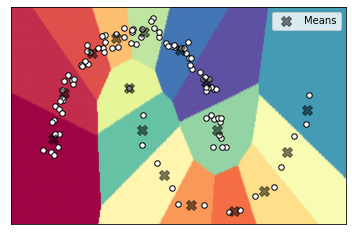

In [6]:
labels = np.argmax(np.stack([[n.x for n in each] for each in p]),axis=1)
labels = labelsort(x,labels)
centroids = np.stack([np.mean(x[labels==each],0)for each in np.unique(labels)])

ax = plot_partition_2D(x,centroids)
ax.set_xlim([-1.5,2.5])
ax.set_ylim([-.6,1.2])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Step 4: Minimize intra-cluster distance

In [7]:
model = gp.Model('cons_kmeans')

p = []
for i in range(N):
    for a in range(k):
        p.append(model.addVar(vtype=GRB.BINARY,name="occupancy"))
p = np.stack(p).reshape(N,k)

r=r2

model.setObjective(
    sum(
        [p[i,a]*np.linalg.norm(
            x[i]-centroids[a]
        ) for i in range(N) for a in range(k)]
    ),GRB.MINIMIZE)

model.addConstrs(p[:,a] @ np.ones(N) <= card_upper for a in range(k))
model.addConstrs(p[:,a] @ np.ones(N) >= 1 for a in range(k))
model.addConstrs(p[i,:] @ np.ones(k) == 1 for i in range(N));
model.addConstrs(p[i,a]*d[i,j]*p[j,a] <= 4*r**2 for i in range(N) for j in range(N) for a in range(k));

model.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 48 physical cores, 96 logical processors, using up to 32 threads
Optimize a model with 132 rows, 1600 columns and 4800 nonzeros
Model fingerprint: 0x57cc53e3
Model has 160000 quadratic constraints
Variable types: 0 continuous, 1600 integer (1600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [9e-06, 1e+01]
  Objective range  [2e-02, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e-01, 1e-01]
Presolve removed 16 rows and 0 columns
Presolve time: 2.03s
Presolved: 134900 rows, 68992 columns, 272768 nonzeros
Variable types: 0 continuous, 68992 integer (68992 binary)
Found heuristic solution: objective 106.6289710

Root relaxation: objective 1.123025e+01, 125 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

* 

## Plot

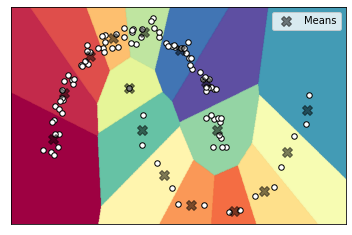

In [8]:
labels = np.argmax(np.stack([[n.x for n in each] for each in p]),axis=1)
labels = labelsort(x,labels)
centroids = np.stack([np.mean(x[labels==each],0)for each in np.unique(labels)])

ax = plot_partition_2D(x,centroids,grid_size=2000)
ax.set_xlim([-1.5,2.5])
ax.set_ylim([-.6,1.2])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [9]:
partition_radius(x,centroids)

array([0.14377745, 0.16415915, 0.12491707, 0.06196598, 0.15455694,
       0.15200805, 0.11899835, 0.13615796, 0.15034659, 0.        ,
       0.17539682, 0.16866777, 0.12658698, 0.1238394 , 0.16641176,
       0.16991628])

In [10]:
k_radius(x,centroids)

array([0.15897693, 0.17072713, 0.12690317, 0.06196598, 0.15455694,
       0.15451336, 0.11899835, 0.13615796, 0.15034659, 0.        ,
       0.19410125, 0.17709071, 0.12658698, 0.1238394 , 0.17735956,
       0.2078113 ])

# Baseline Methods

In [13]:
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained as KCardi
from sklearn_extra.cluster import KMedoids
from kcenter import KCenter

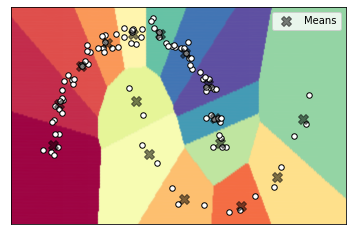

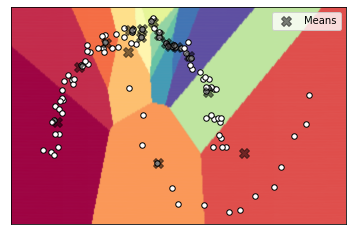

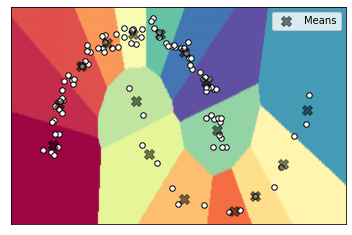

In [12]:
for KMethod in [KMeans,KMedoids,KCenter]:
    
    ## specify k-medoids++ as KMedoids init for paper reported results
    kmethod = KMethod(n_clusters=16, random_state=0)
    kmethod.fit(x)
    labels = kmethod.labels_
    labels = labelsort(x,labels)
    centroids = np.stack([np.mean(x[labels==each],0)for each in np.unique(labels)])
    ax = plot_partition_2D(x,centroids)
    ax.set_xlim([-1.5,2.5])
    ax.set_ylim([-.6,1.2])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

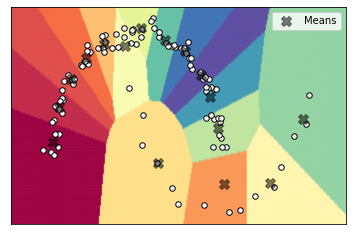

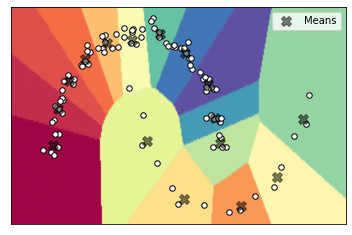

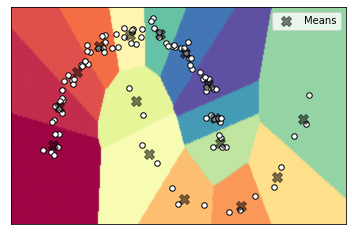

In [22]:
size_min = 1

for size_max in [7,10,N]:
    
    kmeans = KCardi(n_clusters=16,
                               size_max=size_max,
                               size_min = size_min,
                               ).fit(x)

    labels = kmeans.labels_
    labels = labelsort(x,labels)
    centroids = np.stack([np.mean(x[labels==each],0)for each in np.unique(labels)])
    ax = plot_partition_2D(x,centroids)
    ax.set_xlim([-1.5,2.5])
    ax.set_ylim([-.6,1.2])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()